In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import random
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.experimental import CosineDecay

"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
"""
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
"""

# Visaulizing some images from dataset

In [15]:
def visualizing_train_set(num_of_images, train_csv):
    rows = 4
    columns = num_of_images // rows
    #fig, axs = plt.subplots(rows, columns)
    images = []
    images_name = []
    count = 0
    fig = plt.figure(figsize=(20,20))
    for image in tqdm(glob.glob("D://Kaggle_Datasets//train_images//*.jpg")):
        if count == num_of_images:
            break
        else:
            img = cv2.imread(image)
            images.append(img)
            images_name.append(image.split('/')[-1])
            count = count + 1
    """
    count_1 = 0
    for row in range(rows):
        for col in range(columns):
            axs[row, col].imshow(images[count_1])
            title_image = find_the_label(images_name[count_1], train_csv)
            axs[row, col].set_title(title_image)
            count_1 = count_1 + 1
    """        
    axs = []
    for i in range(columns*rows):
        axs.append(fig.add_subplot(rows, columns, i+1) )
        subplot_title = (find_the_label(images_name[i], train_csv))
        axs[-1].set_title(subplot_title)  
        plt.imshow(images[i])
    fig.tight_layout()
    plt.show()
    
def find_the_label(image_name, train_csv):
    i = train_csv.index[train_csv['image_id'] == image_name]
    return train_csv['class_name'].values[i]
    

# Exploring the data by Plotting Graphs

In [16]:
def exploring_the_data(train_csv, _return):
    # gettin the number of positive samples
    cbb = 0
    cbsd = 0
    cgm = 0
    cmd = 0
    healthy = 0
    
    cbb = train_csv.query('label == 0').label.count()
    cbsd = train_csv.query('label == 1').label.count()
    cgm = train_csv.query('label == 2').label.count()
    cmd = train_csv.query('label == 3').label.count()
    healthy = train_csv.query('label == 4').label.count()
    
    # creating a plot with all the data
    label = ['CBB [0]', 'CBSD [1]', 'CGM [2]', 'CMD [3]', 'Healthy [4]']
    fig = plt.figure(figsize = (25,10))
    plt.bar(label, [cbb, cbsd, cgm, cmd, healthy])
    plt.xticks(label, rotation = 45)
    plt.show()
    
    if _return == 1:
        return cbb, cbsd, cgm, cmd, healthy
    else:
        pass

# Performing data oversampling and UnderSampling

In [17]:
# This function is performing oversampling of the classes whose significantly less than the dominant class and it 
# also performs undersampling of the dominant class
# oversampling the dataset
def oversampling_the_data(cbb, cbsd, cgm, cmd, healthy, train_csv, percent):
    print("[*] Old length = {}".format(len(train_csv)))
    train_csv_new = train_csv
    label_dict = {'cbb' : 0, 'cbsd' : 1, 'cgm' : 2, 'cmd' : 3, 'healthy' : 4}
    # finding the percentage of each category and finding which label has a lower percenatage
    cbb_percent = cbb/ (cbb + cbsd + cgm + cmd + healthy)
    cbsd_percent = cbsd/ (cbb + cbsd + cgm + cmd + healthy)
    cgm_percent = cgm/ (cbb + cbsd + cgm + cmd + healthy)
    cmd_percent = cmd/ (cbb + cbsd + cgm + cmd + healthy)
    healthy_percent = healthy/ (cbb + cbsd + cgm + cmd + healthy)
    
    # create a dictionary with the percentage
    percent_dict = {'cbb' : cbb_percent, 'cbsd' : cbsd_percent, 'cgm' : cgm_percent, 'cmd' : cmd_percent, 'healthy' : healthy_percent}
    
    # identifying the highest percent of label
    max_class_value = max(percent_dict, key = percent_dict.get)
    print("[*] Category of class present most is {} with label {}".format(max_class_value, label_dict[max_class_value]))
    
    # increasing the dataset
    for key, value in percent_dict.items():
        print("[*] Dictionary key {}".format(key))
        if key != max_class_value:
            # identifying the label
            label = np.int64(label_dict[key])
            
            for i in range (len(train_csv)):
                if train_csv.iloc[i,1] == label:
                    # using probability to decide whether to add that sample at the end of the dataframe
                    prob = random.uniform(0, 1)
                    if prob >= percent:
                        df = {"image_id" :train_csv.iloc[i,0], "label" : train_csv.iloc[i,1]}
                        train_csv_new = train_csv_new.append(df, ignore_index = True)
    row_index_list = []
    print("Train CSV NEW : \n")
    print(train_csv_new.iloc[5,1])
    for i in range (len(train_csv_new)):
        if train_csv_new.iloc[i,1] == label_dict[max_class_value]:
            prob = random.uniform(0, 1)
            if prob >= percent:
                row_index_list.append(i)
    print("[*]Length of Row Index List is {}".format(len(row_index_list)))
    train_csv_new = train_csv_new.drop(row_index_list)
            
            
        
    print("[*] New length after oversampling = {}".format(len(train_csv_new)))       
    return train_csv_new

# Implementing Stratified K-Fold method

In [18]:
# implementing stratified K-fold
skf = StratifiedKFold(n_splits = 3, random_state = 7, shuffle = True)

# Creating Data generators

In [19]:
# creating data generators 
def creating_data_generators(train_dataframe, train_directory_path, validation_dataframe, y_col_list, Image_Size, Batch_Size):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale = 1./255,
            shear_range=25,
            zoom_range = 0.3,
            horizontal_flip = True,
            rotation_range = 270,
            vertical_flip = True,
            samplewise_std_normalization = True,
            brightness_range=[0.1,0.9],
            width_shift_range=0.2,
            height_shift_range=0.2)
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                  samplewise_std_normalization = True)
    
    train_generator = train_datagen.flow_from_dataframe(
            dataframe = train_dataframe,
            directory = train_directory_path,
            x_col = 'image_id',
            y_col = 'label',
            target_size = (Image_Size, Image_Size),
            batch_size = Batch_Size,
            class_mode = "categorical",
            shuffle = True)
    
    validation_generator = test_datagen.flow_from_dataframe(
            dataframe = validation_dataframe,
            directory = train_directory_path,
            x_col = 'image_id',
            y_col = 'label',
            target_size = (Image_Size, Image_Size),
            batch_size = Batch_Size,
            class_mode = "categorical",
            shuffle = True)
    
    return train_generator, validation_generator

# Creating data generators for Stratified KFold

In [20]:
def creating_data_generators_with_kFoldCV(train_data, image_dir, validation_data, Image_Size, Batch_Size):
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale = 1./255,
            shear_range=25,
            zoom_range = 0.3,
            horizontal_flip = True,
            rotation_range = 270,
            vertical_flip = True,
            samplewise_std_normalization = True,
            brightness_range=[0.1,0.9],
            width_shift_range=0.2,
            height_shift_range=0.2)
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,  samplewise_std_normalization = True)
    train_generator = train_datagen.flow_from_dataframe(
            dataframe = train_data,
            directory = image_dir,
            x_col = 'image_id',
            y_col = 'label',
            target_size = (Image_Size, Image_Size),
            batch_size = Batch_Size,
            class_mode = "categorical")
    validation_generator = test_datagen.flow_from_dataframe(
            dataframe = validation_data,
            directory = image_dir,
            x_col = 'image_id',
            y_col = 'label',
            target_size = (Image_Size, Image_Size),
            batch_size = Batch_Size,
            class_mode = "categorical")    
    
    return train_generator, validation_generator

# Creating the Model

In [21]:
def creating_the_model(model_name, classes, LEARNING_RATE, IMG_Size):
    model = tf.keras.models.Sequential()
    # initialize the model with input shape as (224,224,3)
    if model_name == "InceptionResNet":
        base = tf.keras.applications.InceptionResNetV2(input_shape = (IMG_Size, IMG_Size, 3), include_top = False, weights = 'imagenet')
    if model_name == "ENet":
        base = tf.keras.applications.EfficientNetB4(input_shape = (IMG_Size, IMG_Size, 3), include_top = False, weights = 'imagenet')
    model.add(base)
    model.add(tf.keras.layers.BatchNormalization(axis=-1))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    #model.add(Dropout(0.7))
    #model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax'))
    #for layer in base.layers:
        #layer.trainable = False
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.4,
                                                   name='categorical_crossentropy')
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss = loss,
                        metrics = ['accuracy'])
    
    return model

# Creating Callbacks

In [22]:
# callbacks function
def lr_scheduler(epoch,lr):
    if epoch > 3 and epoch % 2 == 0:
        return lr/1.125
    else :
        return lr

def leraning_rate_scheduler():
    _lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    return _lr_scheduler
def cassava_callback(checkpoint_path):
    _model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True)
    return _model_checkpoint_callback 
"""
def reduce_learning_rate(FACTOR, PATIENCE):
    _reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
    
    return _reduce_learning_rate
"""

"\ndef reduce_learning_rate(FACTOR, PATIENCE):\n    _reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(\n    monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=0,\n    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)\n    \n    return _reduce_learning_rate\n"

# Training the model

In [23]:
def training_the_model_with_generator(cassava_model, train_generator, valid_generator, _model_checkpoint_callback, _lr_scheduler, batch_size, LEARNING_RATE, EPOCH):
    history = cassava_model.fit(
        train_generator,
        steps_per_epoch = len(train_generator)/batch_size,
        epochs = EPOCH,
        validation_data = valid_generator,
        validation_steps = len(valid_generator)/batch_size,
        shuffle=True, callbacks=[_model_checkpoint_callback, _lr_scheduler])
    return history

# Plotting Loss and Accuracy Graphs

In [24]:
def plotting_the_graphs(history):
    #  "Accuracy"
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

# Main function from where all the functions are called

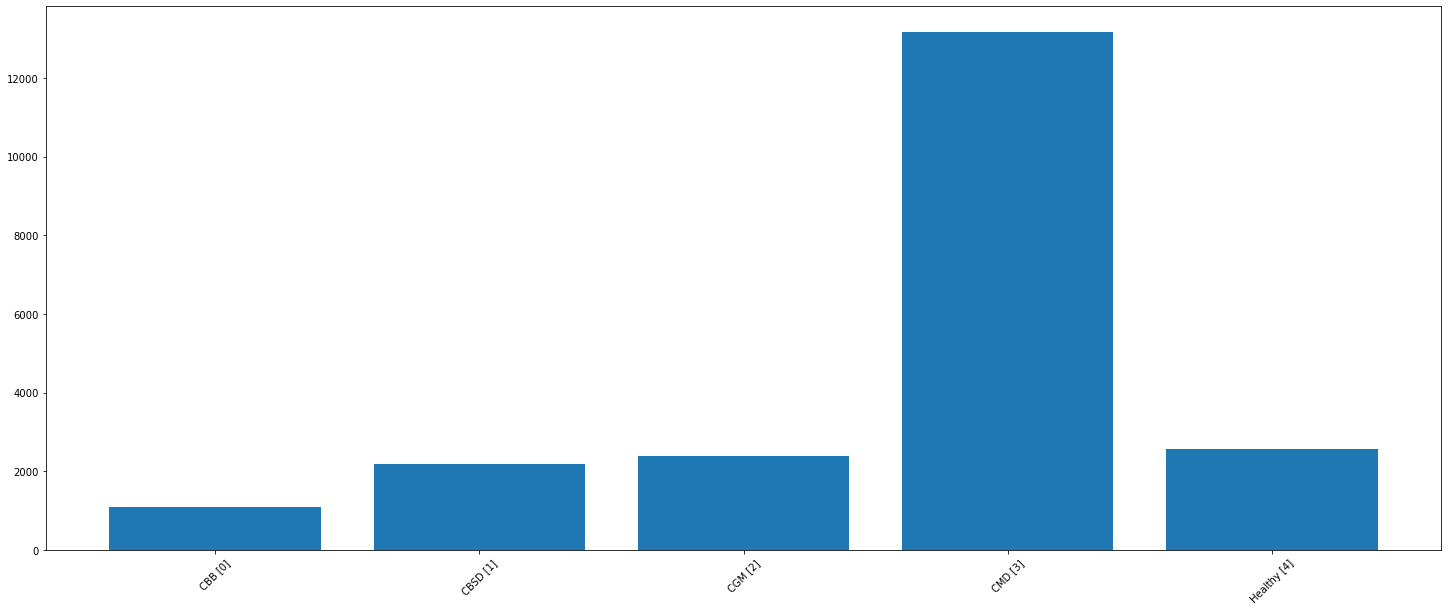

[*] CBB = 1087, CBSD = 2189, CGM = 2386, CMD = 13158, HEALTHY = 2577
[*] New train CSV

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)


  0%|▏                                                                                                                                                                                                   | 20/21397 [00:00<05:17, 67.29it/s]


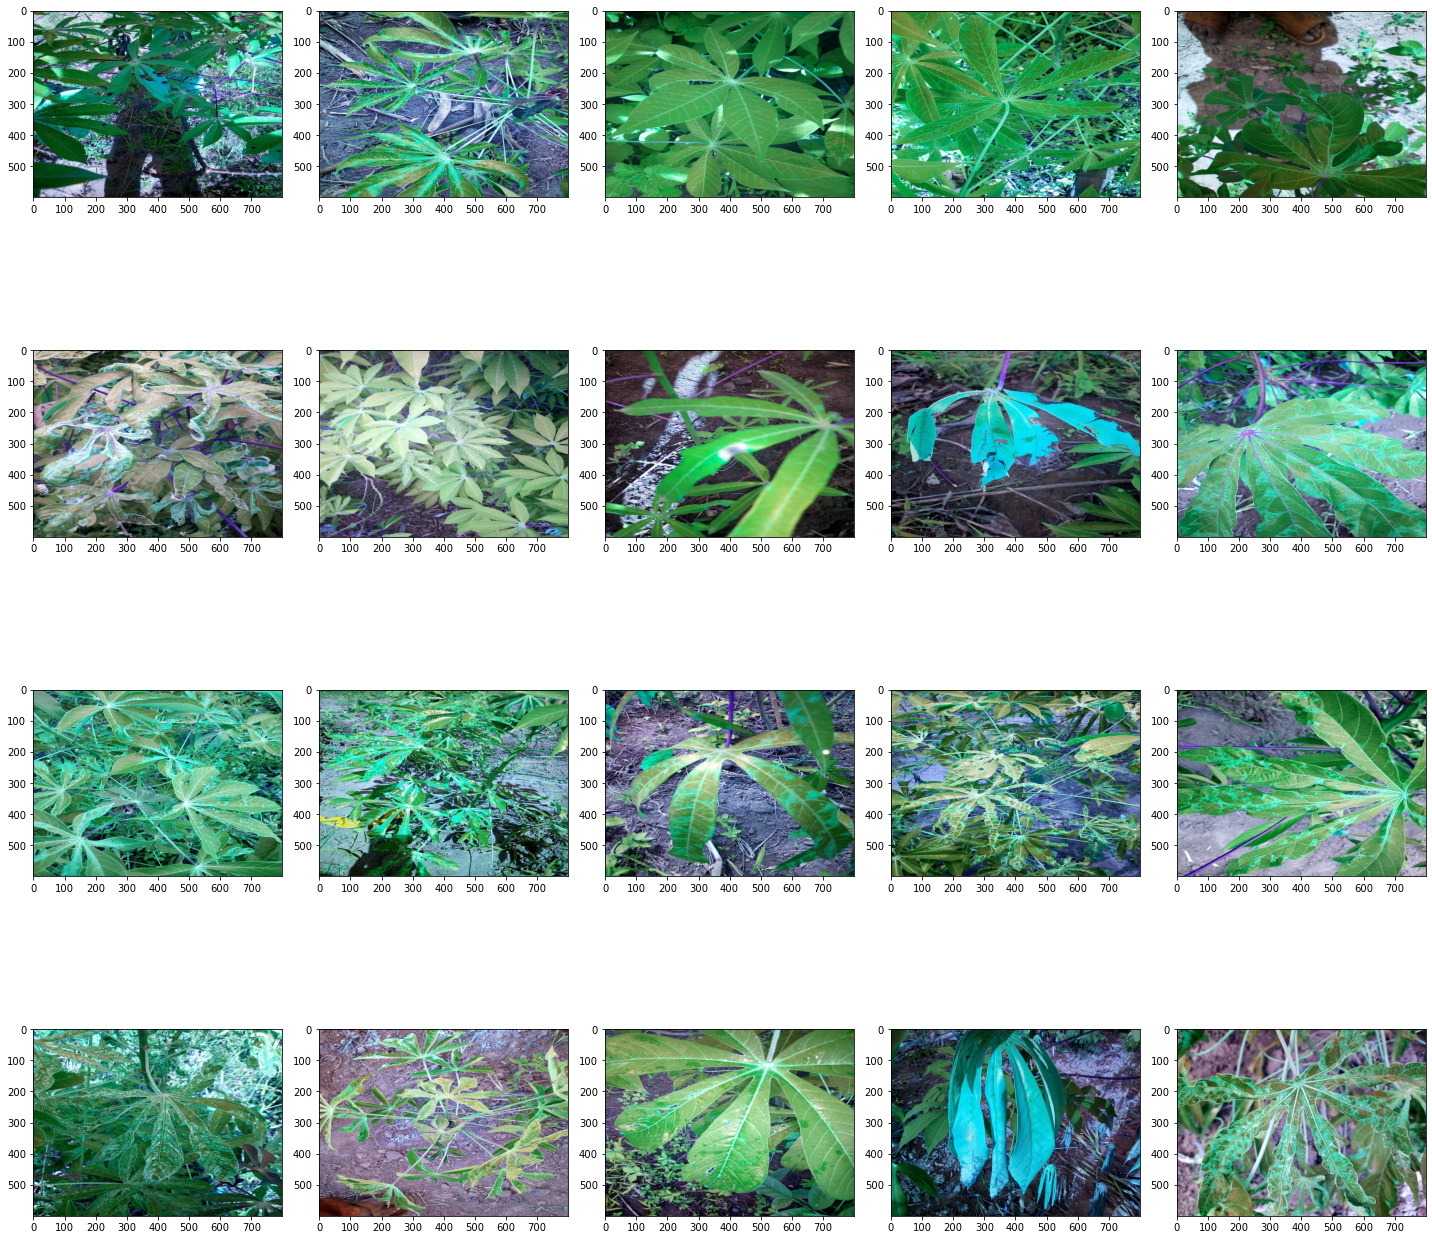

[*] Creating the data generator
[*] Y_COLS : <class 'list'>


C:\Users\bhowm\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.
[*] The model is created
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 14, 14, 1536)      54336736  
_________________________________________________________________
batch_normalization_203 (Bat (None, 14, 14, 1536)      6144      
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)  

KeyboardInterrupt: 

In [25]:
if __name__ == "__main__":
    #boolean variable to check whether to use sratified k fold or not
    if_stratified_kold = False # check to see if we want to use Cross Validation
    perform_oversampling = False # check to see if we want to perform oversampling or undersampling
    use_merged_data = False # check to see if we want to use (2019 + 2020) data
    load_model = False
    
    # name of the model to use
    model_name = "InceptionResNet"  # Either use "ENet" : EfficientNetB4 or use "InceptionResNet" : InceptionResNetV2
    #######################################################
    
    # some general parameters
    EPOCH = 10 #number of epochs
    batch_size = 8 #batch size 
    Image_Size = 512 #Size of image
    classes = 5 #target classes
    LEARNING_RATE = 0.01 #learning rate
    
    if use_merged_data == False:
        train_csv_original = pd.read_csv("D://Kaggle_Datasets//train.csv")
    else:
        train_csv_original = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
    
    with open('D://Kaggle_Datasets//label_num_to_disease_map.json') as json_file:
        data = json.load(json_file)
    # exploring data using graphs
    cbb, cbsd, cgm, cmd, healthy = exploring_the_data(train_csv_original, _return = 1)
    print("[*] CBB = {}, CBSD = {}, CGM = {}, CMD = {}, HEALTHY = {}".format(cbb, cbsd, cgm, cmd, healthy))
    
    
    # oversampling the data and visualizing 
    train_csv = None
    if perform_oversampling == True:
        train_csv = oversampling_the_data(cbb, cbsd, cgm, cmd, healthy, train_csv_original, percent = 0.5)
        print("[*] Plotting data after performing oversampling")
        cbb, cbsd, cgm, cmd, healthy = exploring_the_data(train_csv, _return = 1)
        print("[+] After oversampling the numbers are :\n")
        print("[*] CBB = {}, CBSD = {}, CGM = {}, CMD = {}, HEALTHY = {}".format(cbb, cbsd, cgm, cmd, healthy))
    
        # saving the new dataframe
        #train_csv.to_csv("/kaggle/working/train_csv.csv", index = False)
    else:
        train_csv = train_csv_original

    
    # creating a new column called "class_name" for the dataframe
    with open("D://Kaggle_Datasets//label_num_to_disease_map.json") as f:
        real_labels = json.load(f)
        real_labels = {int(k):v for k,v in real_labels.items()}
    # Defining the working dataset
    train_csv['class_name'] = train_csv['label'].map(real_labels)
    print("[*] New train CSV\n")
    print(train_csv.head(5))
    #train_csv.to_csv("/kaggle/working/train_csv.csv", index = False)
    
        
    # visulaize training data
    visualizing_train_set(20, train_csv)
    
    # path to the train images that will be passed to the data generators
    if use_merged_data == False:
        image_path = 'D://Kaggle_Datasets//train_images'
    else:
        image_path = '../input/cassava-leaf-disease-merged/train'
    
    # this part of if-else is considered if we do not want to perform KFold Cross Validation
    if if_stratified_kold == False:
        # creating the dataset
        # using datagenerator to create dataset
        creating_data_generator = True
        if creating_data_generator:
            print("[*] Creating the data generator")
            #train_csv = pd.read_csv("/kaggle/working/train_csv.csv")
            train_csv['label'] = train_csv.label.astype('str')
            y_cols = train_csv.columns.to_list()[1:]
            print("[*] Y_COLS : {}".format(type(y_cols)))

            # creating data generators
            train_dataframe, test_dataframe = train_test_split(train_csv, test_size = 0.05, random_state = 42, shuffle=True, stratify = train_csv['class_name'])
            train_generator, validation_generator = creating_data_generators(train_dataframe, image_path, test_dataframe, y_cols, Image_Size, batch_size)
        else:
            # creating the dataset using traditional method
            print("[*] Creating the dataset")
            X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded = creating_the_dataset(train_csv, save_image_path)
        
        
        ####### creating the model
        
        if load_model == False:
            cassava_model = creating_the_model(model_name, classes, LEARNING_RATE, Image_Size)
        else:
            cassava_model = tf.keras.models.load_model("../input/cassav-model/cassava_model.h5")
        print("[*] The model is created")
        cassava_model.summary()
        tf.keras.utils.plot_model(cassava_model)
        
        
        
        ###### creating the mkdir
        save_path = 'D://Kaggle_Datasets//model_checkpoint'
        """
        if (os.path.exists(save_path)):
            pass
        else:
            os.mkdir(save_path)
        print("[*] The _model_checkpoint_callback save_path is created")
        """
        ###### creating a callback checkpoint
        checkpoint_path = "D://Kaggle_Datasets//model_checkpoint//cassava_model.h5"
        _model_checkpoint_callback = cassava_callback(checkpoint_path)

        ## controlling learning rate parameters
        FACTOR = 0.1
        PATIENCE = 5
        #reduce_learning_rate = reduce_learning_rate(FACTOR, PATIENCE)
        _lr_scheduler = leraning_rate_scheduler()
        ###### training the model
        ## learning parameters
        if creating_data_generator: 
            print("[*] Training the model with generator")
            history = training_the_model_with_generator(cassava_model, train_generator, validation_generator, _model_checkpoint_callback, _lr_scheduler, batch_size, LEARNING_RATE, EPOCH)
        else:
            print("[*] Training the model without generator")
            history = training_the_model(cassava_model, X_train, y_train_encoded, X_val, y_val_encoded, _model_checkpoint_callback)


        ###### plotting the accuracy graphs
        print("[*] Plotting the model accuracy and loss")
        plotting_the_graphs(history)
        
        ## Evaluating the Best model
        # loading the best model
        cassava_model = tf.keras.models.load_model("D://Kaggle_Datasets//model_checkpoint//cassava_model.h5")
        # loading the test image and resizing and predicting
        predictions = []
        sample_submission = pd.read_csv('D://Kaggle_Datasets//sample_submission.csv')

        for image in sample_submission.image_id:
            test_image = tf.keras.preprocessing.image.load_img('D://Kaggle_Datasets//test_images//' + image)
            test_image = tf.keras.preprocessing.image.img_to_array(test_image)
            test_image = tf.keras.preprocessing.image.smart_resize(test_image, (Image_Size, Image_Size))
            test_image = tf.reshape(test_image, (-1, Image_Size, Image_Size, 3))
            test_prediction = cassava_model.predict(test_image/255)
            predictions.append(np.argmax(test_prediction))

        submission = pd.DataFrame({'image_id': sample_submission.image_id, 'label': predictions})
        submission.to_csv('submission.csv', index=False)
        
        print("Submission File:")
        print(submission.head()) # output
        
    ## this part of handles if we want to perform Cross Validation using Stratified KFold
    else:
        print ("[*] Training with Stratified KFold")
        # implementing if "if_stratified_k_fold" is  True
        
        train_csv['label'] = train_csv.label.astype('str')
        Y = train_csv['label']
        fold_num = 0 # counter for fold number
        for train_index, val_index in skf.split(np.zeros(len(Y)),Y):
            # creating training and validation data using folds 
            print("[*] print : {}".format(val_index))
            training_data = train_csv.iloc[train_index]
            validation_data = train_csv.iloc[val_index]
            # creating data gneerators using the above created folds
            train_generator, validation_generator = creating_data_generators_with_kFoldCV(training_data, image_path, validation_data, Image_Size, batch_size)
                
            ####### creating the model
            cassava_model = creating_the_model(model_name, classes, LEARNING_RATE, Image_Size)
            print("[*] The model is created")
            cassava_model.summary()
            tf.keras.utils.plot_model(cassava_model)

            ###### creating the mkdir
            
            save_path = 'D://Kaggle_Datasets//model_checkpoint'
            """
            if (os.path.exists(save_path)):
                pass
            else:
                os.mkdir(save_path)
            print("[*] The _model_checkpoint_callback save_path is created")
            """
            ###### creating a callback checkpoint
            checkpoint_path = "D://Kaggle_Datasets//model_checkpoint//cassava_model_{}.h5".format(fold_num)
            _model_checkpoint_callback = cassava_callback(checkpoint_path)

            ## controlling learning rate parameters
            FACTOR = 0.1
            PATIENCE = 5
            #_reduce_learning_rate = reduce_learning_rate(FACTOR, PATIENCE)
            _lr_scheduler = leraning_rate_scheduler()
            
            ###### training the model
            print("[*] Training the model for fold : {}".format(fold_num))
            history = training_the_model_with_generator(cassava_model, train_generator, validation_generator, _model_checkpoint_callback, _lr_scheduler, batch_size, LEARNING_RATE, EPOCH)
        

            ###### plotting the accuracy graphs
            print("[*] Plotting the model accuracy and loss")
            plotting_the_graphs(history)
            fold_num = fold_num + 1
            
        # Predicting using all the models and taking the best prediction
        final_prediction = [] # list of all the predictions for each model from which we choose the best model
        sample_submission = pd.read_csv('D://Kaggle_Datasets//sample_submission.csv')
        for image in sample_submission.image_id:
            test_image = tf.keras.preprocessing.image.load_img('D://Kaggle_Datasets//test_images//' + image)
            test_image = tf.keras.preprocessing.image.img_to_array(test_image)
            test_image = tf.keras.preprocessing.image.smart_resize(test_image, (Image_Size, Image_Size))
            test_image = tf.reshape(test_image, (-1, Image_Size, Image_Size, 3))
            predictions = []
            for files in glob.glob("D://Kaggle_Datasets//model_checkpoint//*.h5"):
                print("[*] Model loaded for prediction : {}".format(files.split('//')[-1]))
                cassava_model = tf.keras.models.load_model(files)
                # loading the test image and resizing and predicting
                test_prediction = cassava_model.predict(test_image/255)
                predictions.append(np.argmax(test_prediction))
            final_prediction.append(max(predictions,key=predictions.count))
            
        submission = pd.DataFrame({'image_id': sample_submission.image_id, 'label': final_prediction})
        submission.to_csv('submission.csv', index=False)
        
        print("Submission File:")
        print(submission.head()) # output
            

            

                
            
                

In [27]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16457255431148065017
]
